# Note
Have been having uissuese trying to modify large chunks of code from other sources, so goal with this notebook is to effectively write this whole code from scratch 

In [1]:
## Imports
import torch
import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path

import os
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection import FasterRCNN

from facet_ml.classification import mask_rcnn

import matplotlib.pyplot as plt

In [2]:
# Load pretrained model for fineutning
# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (Solid) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [3]:
# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
    sizes=((16, 32, 64, 128, 256, 512),),
    aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
    featmap_names=['0'],
    output_size=7,
    sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
    backbone,
    num_classes=2,
    rpn_anchor_generator=anchor_generator,
    box_roi_pool=roi_pooler
)

In [4]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
        transforms.append(T.RandomVerticalFlip(0.5))
        transforms.append(T.RandomRotation(90))
        # transforms.append(T.RandomResizedCrop(size=256, scale=(0.6, 1.4)))
        transforms.append(T.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1))
        # transforms.append(T.RandomCrop(size=(224, 224)))


    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [5]:
## Load Data ##

device = "cuda"
# Coco folder
coco_dir = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\ProcessedData\Coco_v5"
coco_dir_train = str( Path(coco_dir) / "train" )
coco_dir_test = str( Path(coco_dir) / "test" )

cd_train = mask_rcnn.ManualCocoColloidalDataset(coco_dir_train, 
                                             str(Path(coco_dir_train) / "_annotations.coco.json"),
                                             transforms=get_transform(True)
                                             )
cd_test = mask_rcnn.ManualCocoColloidalDataset(coco_dir_test, 
                                            str(Path(coco_dir_test) / "_annotations.coco.json"),
                                            transforms=get_transform(False)
                                            )

def collate_fn(batch):
    '''
    Collation function receives [(image_1, targets_1{masks,boxes,labels}), (image_10, targets_1{masks,boxes,labels})...]
    Need to stack image_1
    '''
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    # return tuple(zip(*batch))
    return images,targets

dataloader_train = DataLoader(
    cd_train,
    batch_size=2,
    num_workers=0,
    collate_fn=collate_fn
)
dataloader_test = DataLoader(
    cd_test,
    batch_size=2,
    num_workers=0,
    collate_fn=collate_fn
)

In [6]:
# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.5 # .0005 starting
)
optimizer = torch.optim.Adam(
    params,
    lr=0.000165,
    betas=[0.5, 0.999],
    weight_decay=0.000618,

)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.6
)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma = .512368
)

# let's train it just for 2 epochs
num_epochs = 100

metric_loggers = []
total_losses = []
from engine import train_one_epoch,evaluate

def validate(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    all_predictions = []
    
    with torch.no_grad():  # Disable gradient computation
        for images, targets in dataloader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            # Forward pass (get the model's predictions)
            outputs = model(images)
            
            # Calculate loss (same loss used in training, if applicable)
            loss_dict = model(images, targets)
            print(loss_dict)
            print(loss_dict[0].keys())
            losses = sum(loss for loss in loss_dict.values())
            val_loss += losses.item()
            
            all_predictions.append(outputs)

    avg_val_loss = val_loss / len(dataloader)
    return avg_val_loss, all_predictions

for epoch in range(num_epochs):
    # Train epochs
    metric_logger, losses = train_one_epoch(model, optimizer, dataloader_train, device,epoch,print_freq=1)
    # metric_loggers.append( train_one_epoch(model, optimizer, dataloader_train, device,epoch,print_freq=1) )
    total_losses.append(losses)

    lr_scheduler.step()

    # # evaluate(model,dataloader_test,device=device) # This function is very buggy
    # avg_val_loss, _ = validate(model,dataloader_test,device=device)
    # print(avg_val_loss)

    

c:\Users\Jacob\miniconda3\envs\colloidal_crystal_env\lib\site-packages\torchvision\tv_tensors\_tv_tensor.py:32: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.as_tensor(data, dtype=dtype, device=device).requires_grad_(requires_grad)


Epoch: [0]  [0/2]  eta: 0:00:25  lr: 0.000165  loss: 8.1374 (8.1374)  loss_classifier: 0.6881 (0.6881)  loss_box_reg: 0.7872 (0.7872)  loss_mask: 2.1205 (2.1205)  loss_objectness: 4.2564 (4.2564)  loss_rpn_box_reg: 0.2853 (0.2853)  time: 12.8345  data: 11.5275  max mem: 3494
Epoch: [0]  [1/2]  eta: 0:00:13  lr: 0.000165  loss: 7.4508 (7.7941)  loss_classifier: 0.6696 (0.6789)  loss_box_reg: 0.7515 (0.7693)  loss_mask: 2.0670 (2.0937)  loss_objectness: 3.7680 (4.0122)  loss_rpn_box_reg: 0.1947 (0.2400)  time: 13.7846  data: 12.8350  max mem: 4591
Epoch: [0] Total time: 0:00:27 (13.7849 s / it)
Epoch: [1]  [0/2]  eta: 0:00:25  lr: 0.000165  loss: 2.6329 (2.6329)  loss_classifier: 0.4839 (0.4839)  loss_box_reg: 0.7804 (0.7804)  loss_mask: 0.9928 (0.9928)  loss_objectness: 0.1869 (0.1869)  loss_rpn_box_reg: 0.1889 (0.1889)  time: 12.6896  data: 12.1693  max mem: 4591
Epoch: [1]  [1/2]  eta: 0:00:14  lr: 0.000165  loss: 1.9601 (2.2965)  loss_classifier: 0.3658 (0.4249)  loss_box_reg: 0.7117

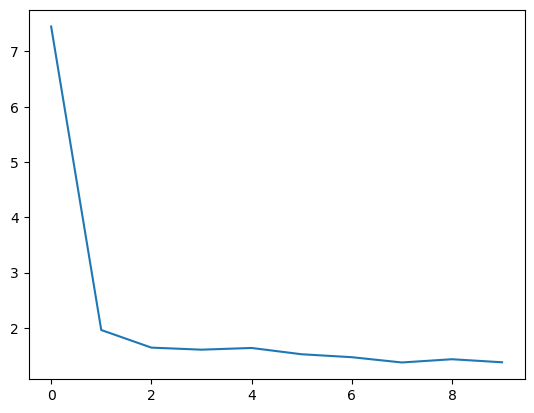

In [7]:
import matplotlib.pyplot as plt
plt.plot(range(len(total_losses)),[l.to("cpu").detach().numpy() for l in total_losses])

In [8]:
cd_test[0]

(tensor([[[0.3490, 0.3490, 0.3490,  ..., 0.3529, 0.3529, 0.3529],
          [0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529],
          [0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.3490, 0.3490, 0.3490,  ..., 0.3529, 0.3529, 0.3529],
          [0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529],
          [0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529],
          ...,
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039],
          [0.0039, 0.0039, 0.0039,  ..., 0.0039, 0.0039, 0.0039]],
 
         [[0.3490, 0.3490, 0.3490,  ..., 0.3529, 0.3529, 0.3529],
          [0.3529, 0.3529, 0.3529,  ..., 0.3529, 0.3529, 0.3529],
          [0.3529, 0.3529, 0.3529,  ...,

In [9]:
## Target image
image_oi, targets_oi = cd_test[0]

targets_oi = [
    {
        k: v.to(device) if isinstance(v, torch.Tensor) else v
        for k, v in targets_oi.items()
    }
]
model.train()
out = model([ image_oi.to("cuda") ],targets_oi)

In [10]:
out

{'loss_classifier': tensor(0.2747, device='cuda:0', grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.4860, device='cuda:0', grad_fn=<DivBackward0>),
 'loss_mask': tensor(0.2891, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_objectness': tensor(0.0549, device='cuda:0',
        grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.3635, device='cuda:0', grad_fn=<DivBackward0>)}

In [11]:
model.eval()
out = model([ image_oi.to("cuda") ])

In [12]:
# pred = out[0]["masks"]
# print(len(pred))
# for mask in pred:
#     plt.imshow(np.sum( np.array(pred.to("cpu").detach())[0], axis=0))
#     plt.show()

{'boxes': tensor([[881.5194, 431.1199, 942.5432, 480.0753],
        [832.3737, 679.2098, 904.3468, 753.7839],
        [738.0322, 708.0727, 811.1359, 781.8708],
        [ 91.4415, 235.2365, 258.2093, 396.5894],
        [876.1756, 475.2100, 930.7964, 529.1888],
        [717.6379, 587.5307, 790.8303, 690.4729],
        [620.9700, 500.5977, 784.8721, 592.0826],
        [847.2984, 473.8452, 883.7079, 520.4261],
        [ 98.0569, 237.1441, 192.6861, 319.6432],
        [888.6728, 496.5694, 972.9337, 563.5568],
        [ 63.4528, 304.0320, 113.0629, 338.2894],
        [769.0195, 570.6581, 854.2517, 638.0574],
        [783.3787, 615.4265, 867.0778, 717.4006],
        [741.8444, 509.9932, 788.8335, 561.5131],
        [866.6411, 427.7161, 979.3375, 562.8934],
        [135.9413, 269.4242, 245.7546, 382.6211],
        [926.9210, 456.4878, 993.1399, 509.5865],
        [935.5042, 458.5104, 981.1078, 488.8491],
        [870.1820, 469.3121, 954.0400, 545.8290],
        [929.8555, 478.7176, 958.9579, 5

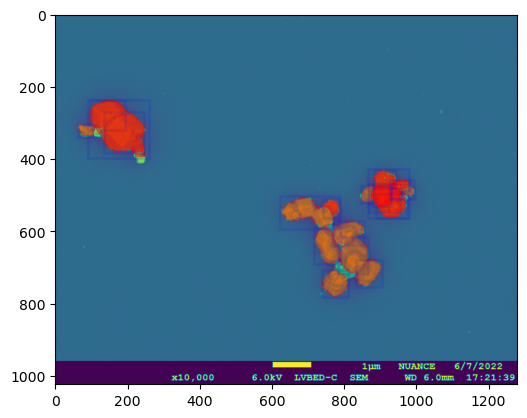

In [13]:
targets = targets_oi[0]
targets = out[0]
print(targets)

masks = targets["masks"]
print("masks:", masks.shape)
boxes = targets["boxes"]
labels = targets["labels"]
scores = targets.get("scores",None)


import matplotlib.patches as patches
from matplotlib.path import Path as plt_Path 
def draw_polygon_with_paths(box,ax):
    # rect = patches.Rectangle( (box[3],box[1]), box[2], box[0],face_color=None)
    vertices = [
        (box[0],box[1]), # Topleft
        (box[0],box[3]), # Bottom Left
        (box[2],box[3]), # Bottom Right
        (box[2],box[1]), # Top Right
        (box[0],box[1])  # Top Left
    ]
    codes = [
        plt_Path.MOVETO,  # Move to the first point (start)
        plt_Path.LINETO,  # Line to the second point
        plt_Path.LINETO,  # Line to the third point
        plt_Path.LINETO,  # Line to the fourth point
        plt_Path.CLOSEPOLY  # Close the path (back to the start)
    ]
    path = plt_Path(vertices, codes)
    patch = patches.PathPatch(path, facecolor='none', edgecolor='blue', linewidth=2,alpha=.1)
    ax.add_patch(patch)

def draw_mask_with_mask(mask,ax):
    from matplotlib.colors import ListedColormap, Normalize
    cmap = ListedColormap(['none', 'red'])
    ax.imshow(mask,cmap=cmap,alpha=.5)

fig, ax = plt.subplots()
ax.imshow(image_oi[0,:,:])

from IPython.display import clear_output
for ii in range(len(masks)):
    if scores is not None:
        
        if scores[ii] < .5:
            continue
    if len(masks[ii].shape) == 3:
        mask = masks[ii][0].to("cpu").detach()
    else:
        mask = masks[ii].to("cpu").detach()
    # mask = masks[ii][0].to("cpu").detach()
    box = boxes[ii].to("cpu").detach()
    label = labels[ii]
    
    draw_polygon_with_paths(box,ax)
    draw_mask_with_mask(mask,ax)
    # print(box)
    # plt.show()
    # from time import sleep
    # sleep(.1)
    # clear_output(wait=True)

plt.show()


In [14]:
out[0]["scores"]

tensor([0.9057, 0.8924, 0.8819, 0.8767, 0.8490, 0.8342, 0.8166, 0.7886, 0.7864,
        0.7860, 0.7798, 0.7724, 0.7575, 0.7303, 0.6869, 0.6770, 0.6734, 0.6089,
        0.5237, 0.5172, 0.4859, 0.4762, 0.4615, 0.4570, 0.4077, 0.4039, 0.3990,
        0.3534, 0.3270, 0.3126, 0.3086, 0.2919, 0.2730, 0.2515, 0.2425, 0.2378,
        0.2232, 0.2179, 0.2105, 0.1946, 0.1875, 0.1804, 0.1688, 0.1682, 0.1361,
        0.1291, 0.1230, 0.1175, 0.1078, 0.1067, 0.1061, 0.1004, 0.1001, 0.0987,
        0.0958, 0.0946, 0.0904, 0.0866, 0.0855, 0.0849, 0.0818, 0.0787, 0.0783,
        0.0738, 0.0719, 0.0712, 0.0709, 0.0706, 0.0692, 0.0598, 0.0589, 0.0551,
        0.0518], device='cuda:0', grad_fn=<IndexBackward0>)

In [15]:
next_item = next(iter(dataloader_train))

In [16]:
np.shape(next_item[1])
next_item[1][0]

{'boxes': BoundingBoxes([[ 844.,    0., 1028.,  105.],
                [ 938.,   39.,  978.,   97.],
                [ 906.,   71.,  954.,  127.],
                [ 906.,  121.,  985.,  206.],
                [ 936.,  126.,  974.,  171.],
                [ 949.,   80., 1006.,  148.],
                [ 987.,  101., 1010.,  128.],
                [1034.,  177., 1075.,  222.],
                [1035.,  153., 1063.,  185.],
                [ 988.,   66., 1049.,  137.],
                [1009.,  123., 1049.,  172.],
                [ 886.,  147.,  928.,  200.],
                [ 870.,   46.,  912.,  155.],
                [ 929.,  213.,  974.,  259.],
                [ 940.,  252.,  971.,  288.],
                [1035.,  244., 1097.,  323.],
                [ 967.,  172., 1064.,  306.],
                [1124.,  420., 1154.,  456.],
                [1130.,  489., 1202.,  568.],
                [ 950.,  937., 1070., 1023.],
                [ 533.,  737.,  676.,  886.],
                [ 426.,  

In [17]:
# next_item.shape

AttributeError: 'tuple' object has no attribute 'shape'

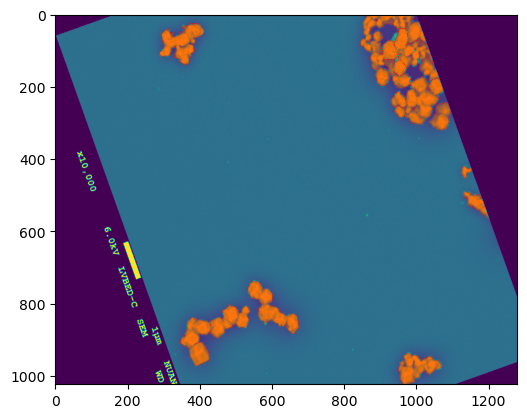

In [18]:
img_load, targets_load = (next_item[0][0],next_item[1][0])
fig, ax = plt.subplots()
ax.imshow(img_load[0,:,:])

masks_load = targets_load["masks"]

for ii in range(masks_load.shape[0]):
    mask = masks_load[ii]
    draw_mask_with_mask(mask,ax)
plt.show()

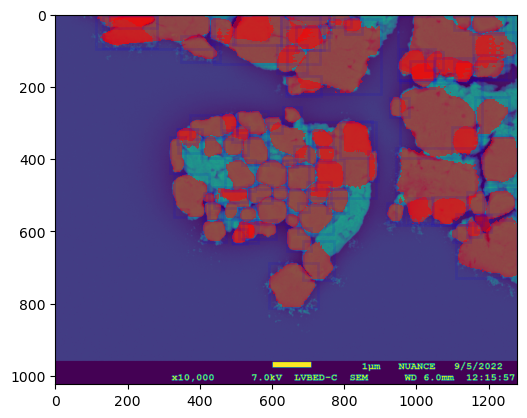

In [27]:
## Check model with completely new image
image_dir = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\Images\Additional\L1_2.5_5_10_nM\L1 2.5 nM"
image_path = r"C:\Users\Jacob\Desktop\Academics\Mirkin\colloidal_crystal_ML\Images\Additional\L1_2.5_5_10_nM\L1 2.5 nM\L1_2.5nM_003.jpg"

import cv2
import glob
img_list = glob.glob( str(Path(image_dir) / "*") )
im = cv2.imread(image_path)
im = cv2.imread(img_list[1])
im_torch = torch.tensor(np.moveaxis(im,-1,0)).to("cuda") / 255
out = model([im_torch])
fig, ax = plt.subplots()
ax.imshow(im[:,:,0])

masks = out[0]["masks"]
boxes = out[0]["boxes"]
scores = out[0]["scores"]

for ii,mask in enumerate(masks):
    score = scores[ii]
    if score < .5:
        continue
    draw_mask_with_mask(mask.to("cpu").detach()[0],ax)
    box = boxes[ii].to("cpu").detach()
    draw_polygon_with_paths(box,ax)

In [32]:
len(cd_train.coco["annotations"]) + len(cd_test.coco["annotations"])

384

In [31]:
torch.save(model,"maskrcnn.pth")